In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tempfile

import seaborn as sb
sb.set_theme()

#### INPUTS

In [44]:
inputFile = 'pkm_modestats.txt'
fuelPrice = 1.8 # eur/lt
carOccupancy = 1.4
 
# Share - total must be 1
shICEV = 1.0
shHEV = 0.0
shEV = 0.0

# Fuel price
fpICEV = fuelPrice # filled from above
fpHEV = fuelPrice  # filled from above
fpEV = 0.2

# Efficiency
efICEV = 5.5    # lt/100km
efHEV = 4.5     # lt/100km
km_kwh = 4.8
efEV = 1/km_kwh # Calculated from km_kwh

### Functions

In [45]:
def roundCond(num):
    if num > 1:
        return round(num, 2)
    else:
        return round(num, 7)


def calc_stats(arr, name):
    z = 1.96

    iterNum = arr.shape[0] - 1
    arr = arr[1:iterNum]
    n = arr.shape[0]

    min = roundCond(arr.min())
    max = roundCond(arr.max())
    mean = roundCond(arr.mean())
    std = roundCond(arr.std())
    q1 = roundCond(np.quantile(arr, 0.25))
    median = roundCond(np.median(arr))
    q3 = roundCond(np.quantile(arr, 0.75))
    cl95_low = roundCond(mean - (z * std) / (iterNum)**(0.5))
    cl95_up = roundCond(mean + (z * std) / (iterNum)**(0.5))

    return {"Name": name, "Min": min, "Max": max, "Mean": mean, "St. dev.": std, 
            "Q1": q1, "Median": median, "Q3": q3, "Cl 95% Lower": cl95_low, "Cl 95% Upper": cl95_up}


def calc_before_after(car_scoot, name):
    # car_scoot is a list [car, scoot] with same car/scooter variables
    car = car_scoot[0]
    scoot = car_scoot[1]

    iterNum = car.shape[0]
    
    before = roundCond(car[0] + scoot[0])
    after = roundCond(car[iterNum-1] + scoot[iterNum-1])
    diff = roundCond(((after - before) / before) *100)

    return { "Name": name, "Before": before, "After": after, "Diff %": diff}


def boxplot(arrays, colNames, title, yLabel):
    # If more than one arrays then concatenate
    if len(arrays) > 1:
        shape = arrays[0].shape[0]
        arrConc = np.concatenate([arrays[0].reshape(shape, 1), 
                                    arrays[1].reshape(shape, 1)], axis=1)
    else:
        arrConc = arrays[0]
    
    df = pd.DataFrame(arrConc, columns=colNames)
    ax = df.plot(kind='box',
                 figsize=(8,8),
                 boxprops=dict(linestyle='-', linewidth=1.5, color="red"),
                 medianprops=dict(linestyle='-', linewidth=1.5, color="blue"),
                 whiskerprops=dict(linestyle='--', linewidth=1.0, color="magenta"),
                 capprops=dict(linestyle='-', linewidth=.75, color="green"),
                 flierprops=dict(marker='o', markeredgecolor='g', markersize=3),
                 showfliers=True, 
                 grid=True, 
                 rot=0)
    ax.set_xlabel('Mode')
    ax.set_ylabel(yLabel)
    ax.set_title(title)

    # Save in a temp file
    tempFile = tempfile.NamedTemporaryFile(suffix='.png')
    plt.savefig(tempFile, dpi=300, facecolor='white')

    plt.show()

    return tempFile

### Read data

In [46]:
df = pd.read_csv(inputFile, sep="\t")

# VTM
# car = car * carOccupancy, escooter is the same
carVKT = df['car'].to_numpy() * carOccupancy
escootVKT = df['escoot'].to_numpy()

iterNum = carVKT.shape[0]

### Indicators

In [47]:
# CAR INDICATORS
car_co2 = (0.11 * carVKT * (shICEV + shHEV + shEV))
car_cost = (efICEV / 100) * fpICEV * (carVKT * shICEV) + (efHEV / 100) * fpHEV * (carVKT * shHEV) + (efEV / 100) * fpEV * (carVKT * shEV)
car_safety = (6 * 10**(-9)) * carVKT

# ESCOOTER INDICATORS
escoot_co2 = ((0.01024 * escootVKT) / 1000)*628
escoot_cost = 1 + 0.9375 * escootVKT
escoot_safety = (30.6 * 10**(-9)) * escootVKT

### Indicators Stats

In [48]:
# Create a dataframe

tables = {
    "Car CO2": car_co2,
    "E-Scooter CO2": escoot_co2,
    "Car cost": car_cost,
    "E-scooter cost": escoot_cost,
    "Car safety": car_safety,
    "E-scooter satefy": escoot_safety 
}

colNames = list(tables.keys())

dataStats = []
for key, val in tables.items():
    dataStats.append(calc_stats(val, key))

df_stats = pd.DataFrame(dataStats)
df_stats

,Name,Min,Max,Mean,St. dev.,Q1,Median,Q3,Cl 95% Lower,Cl 95% Upper
0,Car CO2,461.540000,996.840000,814.950000,152.200000,699.010000,880.110000,939.780000,785.120000,844.780000
1,E-Scooter CO2,13.340000,27.700000,17.300000,3.220000,15.460000,16.350000,17.740000,16.670000,17.930000
2,Car cost,415.380000,897.160000,733.450000,136.980000,629.110000,792.100000,845.810000,706.600000,760.300000
3,E-scooter cost,1945.380000,4039.750000,2523.090000,469.390000,2254.750000,2385.060000,2587.560000,2431.090000,2615.090000
4,Car safety,0.000025,0.000054,0.000044,0.000008,0.000038,0.000048,0.000051,0.000043,0.000046
5,E-scooter satefy,0.000063,0.000132,0.000082,0.000015,0.000074,0.000078,0.000084,0.000079,0.000085


### Indicators box plots

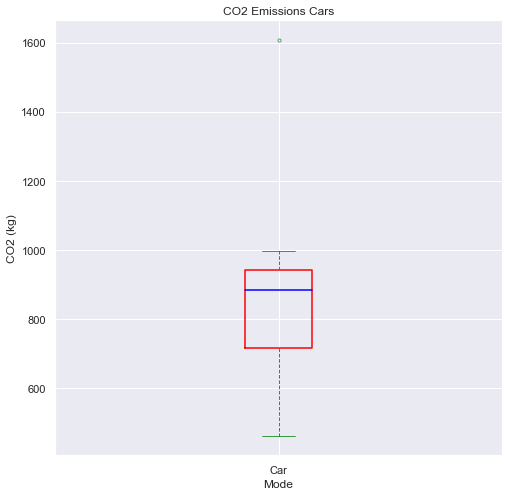

In [49]:
# CAR - CO2
temp3 = boxplot([car_co2], ['Car'], 'CO2 Emissions Cars', 'CO2 (kg)')

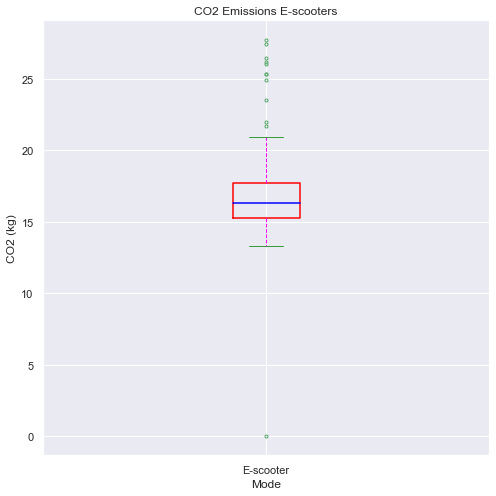

In [50]:
# ESCOOTER - CO2
temp4 = boxplot([escoot_co2], ['E-scooter'], 'CO2 Emissions E-scooters', 'CO2 (kg)')

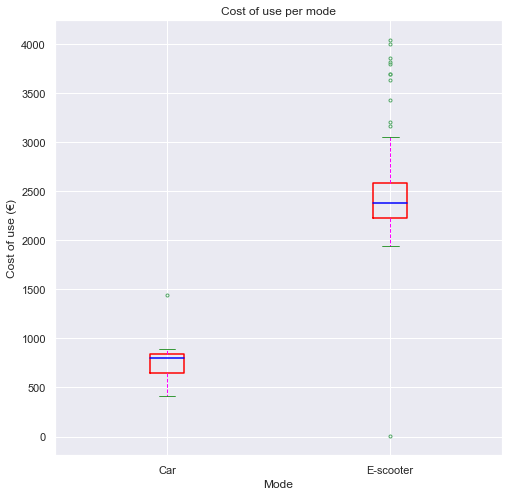

In [51]:
# COST BOX PLOT
temp5 = boxplot([car_cost, escoot_cost], ['Car', 'E-scooter'], 'Cost of use per mode', 'Cost of use (€)')

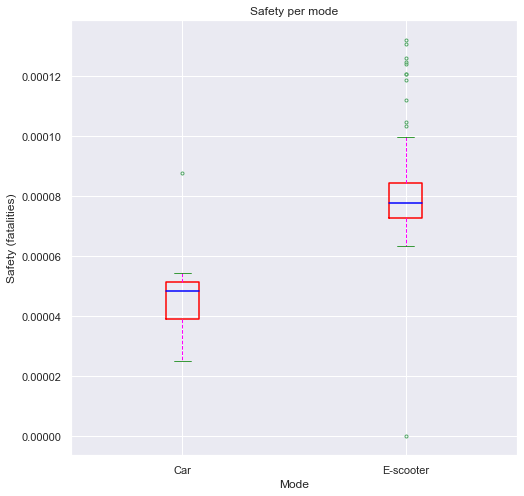

In [52]:
# SAFETY BOX PLOT
temp6 = boxplot([car_safety, escoot_safety], ['Car', 'E-scooter'], 'Safety per mode', 'Safety (fatalities)')

### Calculate Changes

In [53]:
# CO_2 Changes
# Initialize
car_co2_change = np.zeros(iterNum)
car_co2_change_per = np.zeros(iterNum-1)
escoot_co2_change = np.zeros(iterNum)
escoot_co2_change_per = np.zeros(iterNum-1)


for i in range(iterNum):
    car_co2_change[i] = car_co2[i] - car_co2[0]
    escoot_co2_change[i] = escoot_co2[i] - escoot_co2[0]

total_co2_change = car_co2 + escoot_co2

# Percentage
for i in range(1, iterNum):
    car_co2_change_per[i-1] = car_co2_change[i] / car_co2[0]
    escoot_co2_change_per[i-1] = escoot_co2_change[i] / escoot_co2[0]

### Changes Plot

In [54]:
car_scoots = [
    [carVKT, escootVKT],
    [car_co2, escoot_co2],
    [car_cost, escoot_cost],
    [car_safety, escoot_safety]
]

names = ['Vehicle/km', 'CO2 (kg)', 'Cost of use (€)', 'Safety (fatalities)']
dataBA = []
for i, car_scoot in enumerate(car_scoots):
    dataBA.append(calc_before_after(car_scoot=car_scoot, name=names[i]))

df_ba = pd.DataFrame(dataBA)
df_ba

,Name,Before,After,Diff %
0,Vehicle/km,14621.800000,11009.200000,-24.706944
1,CO2 (kg),1607.360000,965.140000,-39.954957
2,Cost of use (€),1456.940000,3081.510000,111.510000
3,Safety (fatalities),0.000088,0.000124,41.480000


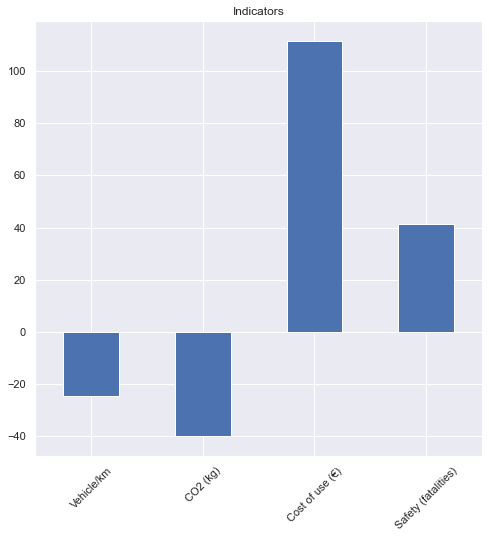

In [55]:
# Changes plot
ax = df_ba.plot.bar(x='Name', y='Diff %', rot=45, legend=False, figsize=(8,8), title='Indicators', xlabel='')
fig = ax.get_figure()

temp7 = tempfile.NamedTemporaryFile(suffix='.xlsx')
fig.savefig(temp7, dpi=300)

### Export

In [56]:
# Temporary file
temp1 = tempfile.NamedTemporaryFile(suffix='.xlsx')
temp2 = tempfile.NamedTemporaryFile(suffix='.xlsx')

# Dataframe write to temp file
df_stats.to_excel(temp1, index=False)
df_ba.to_excel(temp2, index=False)

# Create zip
zipFile = zipfile.ZipFile("sim4mtran_indicators.zip", 'w')

# List with all temps
temps = [temp1, temp2, temp3, temp4, temp5, temp6, temp7]
fileNames = ['1 - Indicators Stats.xlsx', '2 - Changes.xlsx', '3 - CO2 Emissions Cars.png', '4 - CO2 Emissions E-scooters.png', '5 - Cost of use per mode.png', '6 - Safety per mode.png', '7 - Changes.png']

# Write temps in zip
for z, temp in enumerate(temps):
    zipFile.write(temp.name, fileNames[z], zipfile.ZIP_DEFLATED)

# Close zip
zipFile.close()